In [1]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# 3. Feature Engineering - Categorical

## 3.1. Combining Categories / Cross Columns

## Theory

<b>*Combining Categories (CC)*</b> is a simple, powerful technique, but often undervalued. We will use this strategy in other feature engineering techniques, as well, and will introduce its value in a simple example.<br><br>
In some datasets, categories by itself provide no information to predict the target. But if we combine multiple categories, together, then we can indentify patterns.<br><br>
For example, we have the following categories:
<li> Weekday</li>
<li> Hour of the day</li>
Each of them independently has no significant pattern in the dataset. If we combine them with *Weekday_HourOfTheDay*, then we can observe some strong behavior for certainn times on the weekend<br><br>
Decision Trees determine the split in the dataset on single features. If each categorical feature by itself does not provide the information gain, then Decision Trees cannot find a good split. If we provide a combined categorical feature, the Decision Tree can easier split the dataset.

*Combining categories*, also called Cross Column or Cross Product, is used in the [Wide Deep Architecture](https://arxiv.org/abs/1606.07792) by Google and is implemented in [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) 

In [2]:
import IPython

import cudf

import pandas as pd
import numpy as np

In [3]:
f1 = [0]*45 + [1]*45 + [2]*10 + [0]*5 + [1]*5 + [2]*90 + [0]*5 + [1]*5 + [2]*90 + [0]*45 + [1]*45 + [2]*10
f2 = [0]*45 + [0]*45 + [0]*10 + [1]*5 + [1]*5 + [1]*90 + [0]*5 + [0]*5 + [0]*90 + [1]*45 + [1]*45 + [1]*10
t = [1]*45 + [1]*45 + [1]*10 + [1]*5 + [1]*5 + [1]*90 + [0]*5 + [0]*5 + [0]*90 + [0]*45 + [0]*45 + [0]*10

data = cudf.DataFrame({
    'f1': f1,
    'f2': f2,
})

for i in range(3,5):
    data['f' + str(i)] = np.random.choice(list(range(3)), data.shape[0])

data['target'] = t

In [4]:
data.head()

,f1,f2,f3,f4,target
0,0,0,0,0,1
1,0,0,1,1,1
2,0,0,0,2,1
3,0,0,0,0,1
4,0,0,1,2,1


We take a look on the features *f1* and *f2*. Each of the feature provides no information gain as each category has a 0.5 probability for the target.

In [5]:
data.groupby('f1').target.agg(['mean', 'count'])

,mean,count
f1,,
0,0.5,100
1,0.5,100
2,0.5,200


In [6]:
data.groupby('f2').target.agg(['mean', 'count'])

,mean,count
f2,,
0,0.5,200
1,0.5,200


If we analyze the features *f1* and *f2* together, we can observe a significant pattern in the target variable.

In [7]:
data.groupby(['f1', 'f2']).target.agg(['mean', 'count'])

mean  count
f1 f2             
0  0    0.9     50
   1    0.1     50
1  0    0.9     50
   1    0.1     50
2  0    0.1    100
   1    0.9    100

Next, we train a simple Decision Tree to show how combining categories will support the decision boundaries.

In [8]:
df = data.to_pandas()

In [9]:
import pydotplus
import sklearn.tree as tree
from IPython.display import Image

In [10]:
def get_hotn_features(df):
    out = []
    for col in df.columns:
        if col != 'target':
            out.append(pd.get_dummies(df[col], prefix=col))
    return(pd.concat(out, axis=1))

def viz_tree(df, lf):
    dt_feature_names = list(get_hotn_features(df).columns)
    dt_target_names = 'target'
    tree.export_graphviz(lf, out_file='tree.dot', 
                         feature_names=dt_feature_names, class_names=dt_target_names,
                         filled=True)  
    graph = pydotplus.graph_from_dot_file('tree.dot')
    return(graph.create_png())

First, we train it without the combined categories *f1* and *f2*. We can see, that the Decision Trees creates the split on the random features *f3* and *f4*. The leaves have only a small information gain (e.g. 98 negative vs. 82 positive).

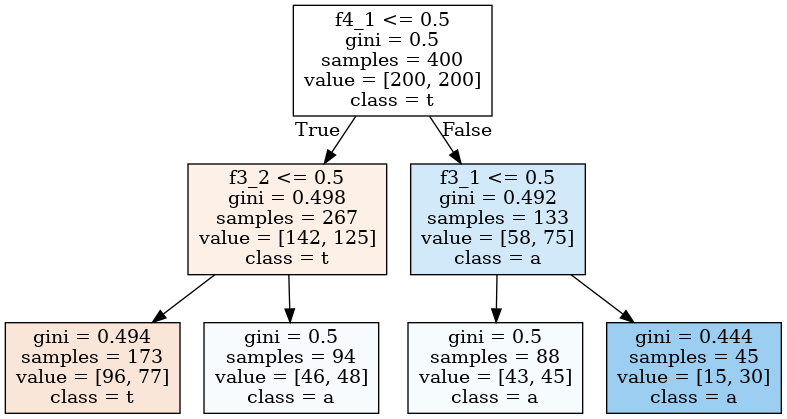

In [11]:
lf = tree.DecisionTreeClassifier(max_depth=2)
lf.fit(get_hotn_features(df), df[['target']])
Image(viz_tree(df, lf))

Now, we combine the categories *f1* and *f2* as an additional feature. We can see that the Decision Tree uses that feature first and that the splits have a high information gain. For example, 190 negative vs. 110 positives.

In [12]:
df['f1_f2'] = df['f1'].astype(str) + df['f2'].astype(str)

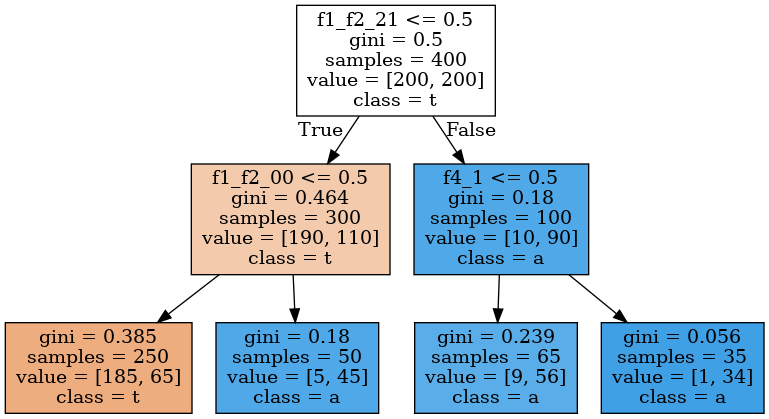

In [13]:
lf.fit(get_hotn_features(df), df[['target']])
Image(viz_tree(df, lf))

This simple technique will be used in combination with other feature engineering techniques.<br><br>
We may have the idea - that is great, let's combine all categories into one feature. Unfortunately, this is not that easy. We want to balance the number of categories used, the number of observations in resulting category values and the information gain:
<li> The more categories we combine, we will identify more underlying patterns - but combining more categories together reduces the number of observation per categoy in the resulting features
<li> Higher number of observation in the resulting category shows a strong pattern and it is more generalizable
<li> High information gain supports our model, but only if it is generalizable

The extreme example is that we combine all features f1, f2, f3 and f4 together. But the observation per category (count) is very small (4-20)

In [14]:
df.groupby([x for x in df.columns if 'target' not in x and 'f1_f2' not in x]).target.agg(['mean', 'count']).head(10)

mean  count
f1 f2 f3 f4                 
0  0  0  0   1.000000      6
         1   1.000000      5
         2   0.750000      4
      1  0   0.750000      4
         1   0.857143      7
         2   1.000000      5
      2  0   0.750000      4
         1   0.750000      4
         2   1.000000     11
   1  0  0   0.000000      6

<b>Best practicse:</b>
<li> Combining low cardinal categories is a good start. For example, the dataset size is 100M rows and there are multiple categories with a caridnality (# of unique values) of 10-50, then combining them should not result in low observation count
<li> Exploratory Data Analysis (EDA) is faster than training a model. Analyzing the information value for different combination of categorical features (on a sample) is really fast.

Example of getting the cardinality for categories:

In [15]:
df.astype(str).describe()

,f1,f2,f3,f4,target,f1_f2
count,400,400,400,400,400,400
unique,3,2,3,3,2,6
top,2,0,1,0,0,21
freq,200,200,136,142,200,100


#### Summary

<li> Combining categories identifies underlying patterns in the dataset<br>
<li> The technique can support Decision Trees to create better splits as Decision Trees analyze features independently of each other<br>

## Practice

Now, it is your turn. What are good combinations of categories in our dataset?<br><br>

**ToDo:**
<li> Define which categorical featueres should be combined? Why should these be combined? What are your hypotheses?

In [16]:
import cudf

In [17]:
df_train = cudf.read_parquet('../data/train.parquet')

In [18]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,<NA>,<NA>,2019-12-01 00:00:28,0,0,6,1,12,2019
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:39,0,0,6,1,12,2019
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:40,0,0,6,1,12,2019
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:41,0,0,6,1,12,2019
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,light,<NA>,2019-12-01 00:01:56,0,1,6,1,12,2019


In [19]:
###ToDo
def explore_cat(df, cats):
    df_agg = df_train[cats + ['target']].groupby(cats).agg(['mean', 'count']).reset_index()
    df_agg.columns = cats + ['mean', 'count']
    print(df_agg.sort_values('count', ascending=False).head(20))
    
cats = ['product_id', 'user_id']  
explore_cat(df_train, cats)

         product_id    user_id      mean  count
640663      1004767  545442548  0.000000    807
620114      1004767  525325337  0.000000    753
1560100     1005107  553431815  0.599185    736
4882910    15300303  512875426  0.000000    709
2021336     1005174  563599039  0.931238    509
1148644     1004873  515032042  0.002041    490
3626024     4804718  536911254  0.000000    471
4154253     8800045  557590749  0.000000    380
3076839     3601537  578263741  0.000000    363
839819      1004833  564068124  0.793872    359
1477094     1005100  611998200  0.000000    333
6442        1002524  515598234  0.677215    316
348093      1004249  513901034  0.648562    313
1301035     1005008  521558076  0.003236    309
1941657     1005161  512924342  0.537162    296
1593381     1005115  516010934  0.750000    288
3631591     4804718  576154686  0.550523    287
5935044   100007950  515481166  0.000000    287
3062423     3601489  513824664  0.000000    275
85419       1002544  545376441  0.896296

In [20]:
############### Solution ###############

In [21]:
cats = ['ts_weekday', 'ts_hour']  
explore_cat(df_train, cats)

     ts_weekday  ts_hour      mean   count
105           4        9  0.306273  135340
104           4        8  0.308886  133648
106           4       10  0.305982  130596
103           4        7  0.302046  127421
127           5        7  0.316684  126271
102           4        6  0.285326  125225
107           4       11  0.296363  125083
128           5        8  0.364706  124991
129           5        9  0.416071  123760
152           6        8  0.414232  122685
154           6       10  0.419844  122286
151           6        7  0.413953  121625
153           6        9  0.408690  121126
130           5       10  0.405588  120901
155           6       11  0.431274  120740
126           5        6  0.315536  120658
101           4        5  0.282200  117562
131           5       11  0.351100  116699
150           6        6  0.415361  115774
156           6       12  0.426867  113457


In [22]:
cats = ['cat_2', 'brand']  
explore_cat(df_train, cats)

               cat_2    brand      mean    count
3363           light  samsung  0.481047  1212393
3165           light    apple  0.469441  1013391
3405           light   xiaomi  0.396346   510657
3258           light   huawei  0.460027   228978
2298       headphone    apple  0.329330   121152
3332           light     oppo  0.505053    98853
3607        massager  samsung  0.406636    85472
6757          vacuum  samsung  0.392459    68239
6966          washer  samsung  0.334397    59208
1293  coffee_grinder  lucente  0.511974    58294
5231   refrigerators  samsung  0.449099    57455
6656              tv  samsung  0.316777    53211
6959          washer       lg  0.333735    47331
2351       headphone   lenovo  0.455475    40483
3431        massager    artel  0.391447    39354
2293       headphone     acer  0.471679    38028
3560        massager       lg  0.395045    34105
5756         slipons  samsung  0.418726    30514
5192   refrigerators  indesit  0.311972    28634
6956          washer

Hypothesis:
* Some user will always buy the same one-way products e.g. cleaning supplies, food
* Behavior changes on weekday+hour - e.g. during the week, users will not stay up late as they work next day
* Category and brand are both powerful features, but the combination can be more important. E.g. do people buy apple smartphones or accessories?

In [23]:
############### Solution End ###########

## Optimization

There is not much optimization technique to apply. We will "chain" the idea of combining categories with other Feature Engineering techniques, which does NOT require us to actually combine and store the new feature in the dataset. Instead, we will create features based on the combined categories directly and won't store the combined categories as a separate feature.<br><br>
One advice is to use cuDF instead of pandas. Analzying the dataset requires calculating different groupby combination multiple times by a data scientist. GPU acceleration can significantly speed-up the calculations and enables you to run more comparisons.

In [24]:
big_df = df_train.to_pandas()
big_data = df_train

In [25]:
print('Pandas Shape:' + str(big_df.shape))
print('cudf Shape:' + str(big_df.shape))

Pandas Shape:(11461357, 19)
cudf Shape:(11461357, 19)


In [26]:
%%time

big_df.groupby(['cat_0', 'cat_1', 'cat_2', 'cat_3', 'brand']).target.agg(['mean', 'count'])
print('')


CPU times: user 3.02 s, sys: 616 ms, total: 3.63 s
Wall time: 3.63 s


In [27]:
%%time

big_data.groupby(['cat_0', 'cat_1', 'cat_2', 'cat_3', 'brand']).target.agg(['mean', 'count'])
print('')


CPU times: user 812 ms, sys: 800 ms, total: 1.61 s
Wall time: 1.61 s


A dataset with 12M rows is ~4-6x faster on GPU with cuDF as on CPU with pandas. This difference can even increase with larger dataset size as the groupby operation is not linear in complexity. 

We shutdown the kernel.

In [28]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}